# Analysis part - Machamp_1st_Edition__Holo_1999_Base_Set

In [1]:
library(ggplot2)
library(quantreg)


df = read.csv('lagged_merged_datasets_final/merged_Machamp_1st_Edition__Holo_1999_Base_Set.csv')

#convert prices to returns
grades <- grep("grade[0-9]+price", names(df), value = TRUE)
grade_returns <- sapply(grades, function(x) paste0(x, "_return"))

for(grade in grades) {
  df[paste(grade, "return", sep = "_")] <- c(NA, diff(log(df[[grade]])))
}

#convert adjclosestock and adjclosebond (including their lags) to returns
stock_bond_cols <- grep("adjclose(stock|bond)(lag[0-9]+)?", names(df), value = TRUE)

for(col in stock_bond_cols) {
  df[paste0(col, "_return")] <- c(NA, diff(log(df[[col]])))
}


#convert volume and its lags to 'returns'
volume_cols <- grep("volume(lag[0-9]+)?", names(df), value = TRUE)

for(col in volume_cols) {
  df[paste0(col, "_return")] <- c(NA, diff(log(df[[col]])))  # Adding 1 to avoid log(0) issues
}

#remove rows with NA in the newly created return columns
df <- na.omit(df)

print(head(df))



Registered S3 methods overwritten by 'ggplot2':
  method         from 
  [.quosures     rlang
  c.quosures     rlang
  print.quosures rlang
Warning message:
"package 'quantreg' was built under R version 3.6.3"Loading required package: SparseM
Warning message:
"package 'SparseM' was built under R version 3.6.3"
Attaching package: 'SparseM'

The following object is masked from 'package:base':

    backsolve



        date grade5price grade6price grade7price grade8price grade9price
2 2016-10-01       14.00    7.500000      15.000      38.110    60.67667
3 2016-11-01       14.00    7.500000       8.500      38.110    64.21000
4 2016-12-01        3.25    9.583333       8.500      27.500    38.13800
5 2017-01-01        3.25    9.583333       8.500      15.935    27.00000
6 2017-02-01        3.25   15.995000      12.005      29.000    40.95250
7 2017-03-01        3.25   11.600000      12.005      17.125    72.05000
  grade10price adjclosestock      volume adjclosebond  stockreturns
2        599.9       2126.15 72915530000        2.589 -0.0194256789
3        599.9       2198.81 88445380000        3.017  0.0341745218
4         70.0       2238.83 75344550000        3.063  0.0182007624
5         70.0       2278.87 70576420000        3.051  0.0178843582
6         70.0       2363.64 69260940000        2.968  0.0371981601
7        633.0       2362.72 81664010000        3.018 -0.0003891971
  bondadjuste

                         grade5price_return grade6price_return
grade5price_return              1.000000000         0.00730433
grade6price_return              0.007304330         1.00000000
grade7price_return              0.201847494         0.07040504
grade8price_return              0.162655565         0.36299157
grade9price_return             -0.007743951         0.16048429
grade10price_return             0.329617853         0.00120399
adjclosestock_return            0.042340672         0.01589451
adjclosebond_return             0.003793239        -0.02979170
adjclosestocklag1_return        0.047447523        -0.16252661
adjclosebondlag1_return         0.017540673        -0.12550883
adjclosestocklag2_return       -0.024405403         0.03416535
adjclosebondlag2_return        -0.003495028        -0.07502457
adjclosestocklag3_return        0.092696665         0.18570266
adjclosebondlag3_return        -0.020034681         0.02143179
adjclosestocklag4_return       -0.085207461        -0.1

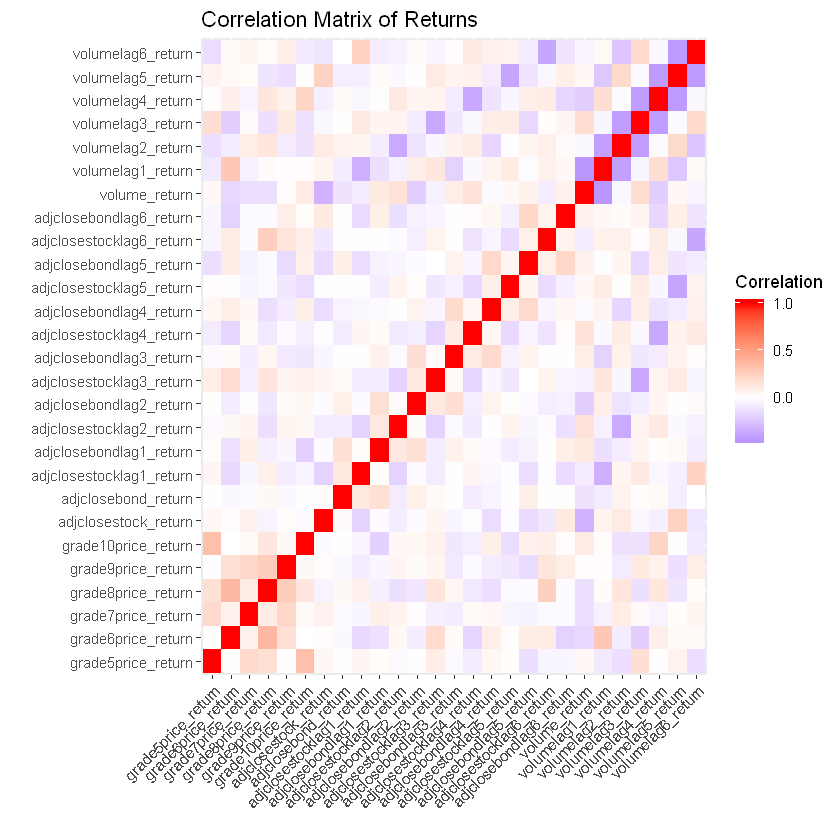

In [2]:
createReturnsCorrelationMatrix <- function(df) {
  # Load necessary libraries
  library(ggplot2)
  library(reshape2)
  
  # Use a simplified pattern to include both "_return" columns and any "volume" columns
  pattern <- "_return"
  selected_columns <- grep(pattern, names(df), value = TRUE)
  
  # Calculate the correlation matrix for the selected columns
  correlation_matrix <- cor(df[, selected_columns], use = "complete.obs")
  
  # Print the correlation matrix to the console
  print(correlation_matrix)
  
  # Melt the correlation matrix for visualization
  melted_correlation_matrix <- melt(correlation_matrix)
  
  # Create the ggplot object for the correlation matrix
  plot <- ggplot(data = melted_correlation_matrix, aes(x=Var1, y=Var2, fill=value)) +
    geom_tile() +
    scale_fill_gradient2(midpoint=0, low="blue", high="red", mid="white") +
    theme(axis.text.x = element_text(angle = 45, hjust = 1)) +
    labs(x='', y='', title='Correlation Matrix of Returns', fill='Correlation')
  
  # Explicitly print the ggplot object to ensure it's displayed
  print(plot)
  
  # Return the correlation matrix as well
  return(correlation_matrix)
}

# Assuming your adjusted dataset is in 'df'
# Example usage:
correlation_matrix <- createReturnsCorrelationMatrix(df)


## VAR model - try later - if enough time...

## Visualisation

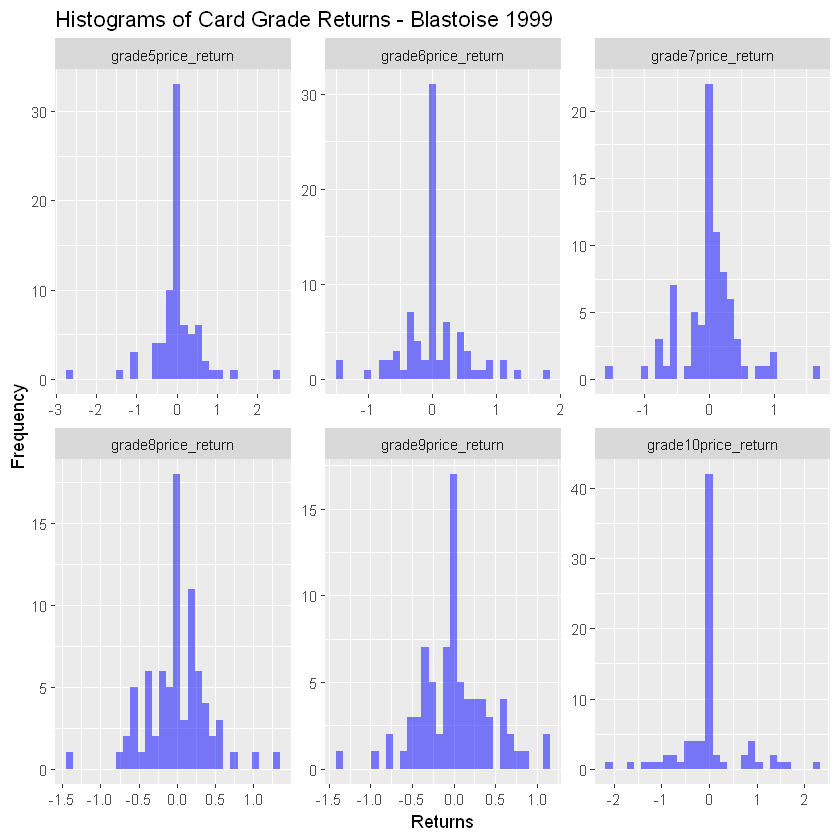

In [3]:

#create a long format data frame suitable for faceting with returns
long_df <- reshape2::melt(df, id.vars = "date", measure.vars = grade_returns)

#histograms for card grade returns
p1 <- ggplot(long_df, aes(x = value)) +
  geom_histogram(bins = 30, fill = "blue", alpha = 0.5) +
  facet_wrap(~ variable, scales = "free") +
  labs(x = "Returns", y = "Frequency", title = "Histograms of Card Grade Returns - Blastoise 1999")

print(p1)

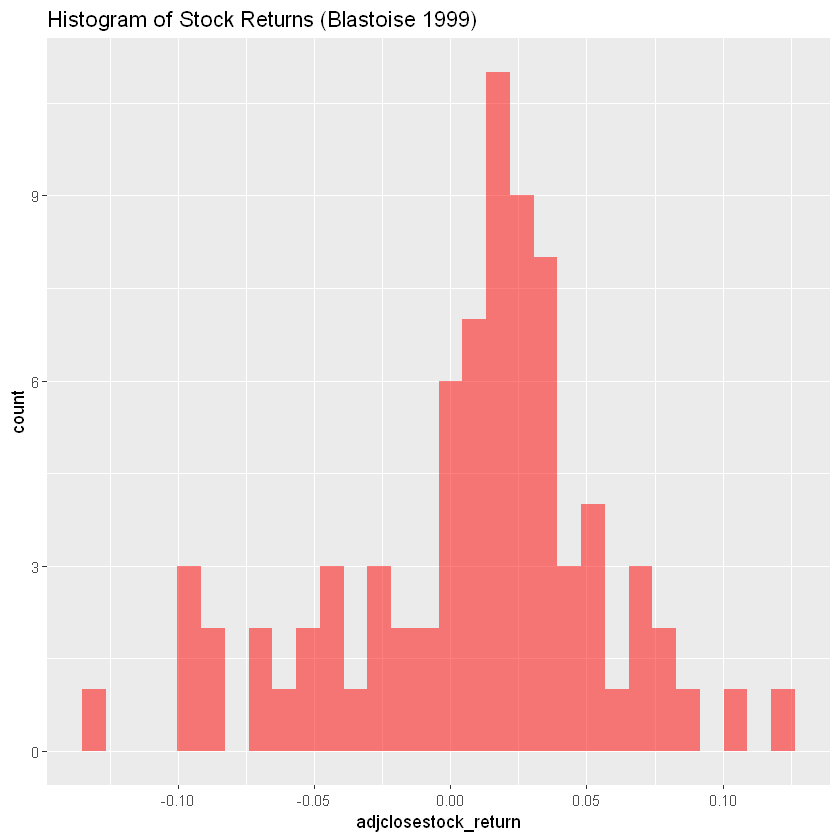

In [4]:
#histogram of stock returns
p2 <- ggplot(df, aes(x = adjclosestock_return)) +
  geom_histogram(bins = 30, fill = "red", alpha = 0.5) +
  labs(title = "Histogram of Stock Returns (Blastoise 1999)")

print(p2)

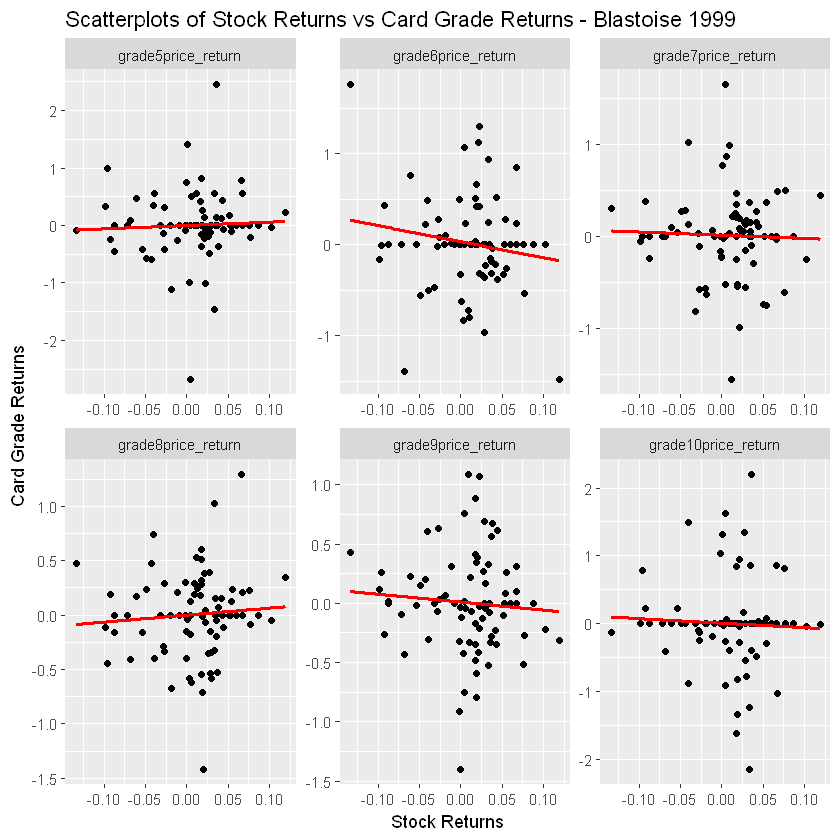

In [5]:
#a long format data frame suitable for scatterplots with returns
long_df <- reshape2::melt(df, id.vars = c("date", "adjclosestocklag1_return"), measure.vars = grade_returns) #ADJUST FOR DIFFERENT LAGS

#scatterplots between stock returns and card grades returns
p3 <- ggplot(long_df, aes(x = adjclosestocklag1_return, y = value)) +
  geom_point() +
  geom_smooth(method = "lm", se = FALSE, color = "red") +
  facet_wrap(~ variable, scales = "free") +
  labs(x = "Stock Returns", y = "Card Grade Returns", title = "Scatterplots of Stock Returns vs Card Grade Returns - Blastoise 1999")

print(p3)

## Choose the variables using AIC

In [7]:

# Load necessary library
library(stats)

# Preparing the initial full model with the dependent variable (choosing one of the grade prices as an example)
# and all potential independent variables (using returns and lagged returns)
# Note: Adjust 'grade5price' to the specific grade price return you are analyzing
full_model <- lm(grade10price_return ~ adjclosestock_return + adjclosebond_return +
                 adjclosestocklag1_return + adjclosebondlag1_return +
                 adjclosestocklag2_return + adjclosebondlag2_return +
                 adjclosestocklag3_return + adjclosebondlag3_return +
                 adjclosestocklag4_return + adjclosebondlag4_return +
                 adjclosestocklag5_return + adjclosebondlag5_return +
                 adjclosestocklag6_return + adjclosebondlag6_return +
                 volume_return + volumelag1_return + volumelag2_return + volumelag3_return + 
                 volumelag4_return + volumelag5_return + volumelag6_return, data = df)

# Perform backward elimination based on AIC
reduced_model <- step(full_model, direction = "backward")

# Display the summary of the reduced model to see the selected variables and their coefficients
summary(reduced_model)


Start:  AIC=-43.51
grade10price_return ~ adjclosestock_return + adjclosebond_return + 
    adjclosestocklag1_return + adjclosebondlag1_return + adjclosestocklag2_return + 
    adjclosebondlag2_return + adjclosestocklag3_return + adjclosebondlag3_return + 
    adjclosestocklag4_return + adjclosebondlag4_return + adjclosestocklag5_return + 
    adjclosebondlag5_return + adjclosestocklag6_return + adjclosebondlag6_return + 
    volume_return + volumelag1_return + volumelag2_return + volumelag3_return + 
    volumelag4_return + volumelag5_return + volumelag6_return

                           Df Sum of Sq    RSS     AIC
- adjclosestocklag4_return  1   0.00029 26.095 -45.509
- adjclosestocklag1_return  1   0.00576 26.100 -45.492
- adjclosebondlag5_return   1   0.00610 26.101 -45.491
- volumelag6_return         1   0.00962 26.104 -45.480
- adjclosebondlag6_return   1   0.02555 26.120 -45.432
- volumelag1_return         1   0.03547 26.130 -45.402
- adjclosestocklag2_return  1   0.10605 26.201


Call:
lm(formula = grade10price_return ~ adjclosebondlag1_return + 
    adjclosestocklag5_return + volume_return + volumelag4_return, 
    data = df)

Residuals:
     Min       1Q   Median       3Q      Max 
-1.80210 -0.23273 -0.01282  0.25390  1.74904 

Coefficients:
                         Estimate Std. Error t value Pr(>|t|)  
(Intercept)               0.03244    0.07278   0.446   0.6571  
adjclosebondlag1_return  -1.75372    0.82012  -2.138   0.0358 *
adjclosestocklag5_return -2.24997    1.52959  -1.471   0.1455  
volume_return             0.75045    0.43111   1.741   0.0859 .
volumelag4_return         1.05845    0.45615   2.320   0.0231 *
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1

Residual standard error: 0.6337 on 74 degrees of freedom
Multiple R-squared:  0.1448,	Adjusted R-squared:  0.09856 
F-statistic: 3.132 on 4 and 74 DF,  p-value: 0.0195


## Models

### OLS

In [10]:
#OLS
ols_model <- lm(grade10price_return ~ adjclosebondlag1_return + 
    adjclosestocklag5_return + volume_return + volumelag4_return, data = df) 

print(summary(ols_model))

library(car)

# Calculate VIF
vif_result <- vif(ols_model)
print(vif_result)

library(lmtest)

# Perform the Breusch-Pagan test
bp_test <- bptest(ols_model)

# Print the test results
print(bp_test)



Call:
lm(formula = grade10price_return ~ adjclosebondlag1_return + 
    adjclosestocklag5_return + volume_return + volumelag4_return, 
    data = df)

Residuals:
     Min       1Q   Median       3Q      Max 
-1.80210 -0.23273 -0.01282  0.25390  1.74904 

Coefficients:
                         Estimate Std. Error t value Pr(>|t|)  
(Intercept)               0.03244    0.07278   0.446   0.6571  
adjclosebondlag1_return  -1.75372    0.82012  -2.138   0.0358 *
adjclosestocklag5_return -2.24997    1.52959  -1.471   0.1455  
volume_return             0.75045    0.43111   1.741   0.0859 .
volumelag4_return         1.05845    0.45615   2.320   0.0231 *
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1

Residual standard error: 0.6337 on 74 degrees of freedom
Multiple R-squared:  0.1448,	Adjusted R-squared:  0.09856 
F-statistic: 3.132 on 4 and 74 DF,  p-value: 0.0195

 adjclosebondlag1_return adjclosestocklag5_return            volume_return 
                1.021287         

No hetersoskedasticity nor multicolinearity

### Quantile regression

In [11]:
#Quantile regression
library(quantreg)

quantile_model <- rq(grade10price_return ~ adjclosebondlag1_return + 
                    adjclosestocklag5_return + volume_return + volumelag4_return, data = df, tau = seq(from=0.05, to=0.95, by=0.05))  #change tau for different quantiles
                                                                                                                                   

#print summary of quantile regression models
for(grade_return in grade_returns) {
  #print(paste("Summary of quantile regression model for:", grade_return))
  #print(summary(quantile_models[[grade_return]]))
}

#uncomment the last two commented rows (in the previous loop) if you want to see the results for quantiles from 0.05 to 0.95, by 0.05 step




#### Results for different quantiles of the grade 10 prices x OLS estimates (red line) 

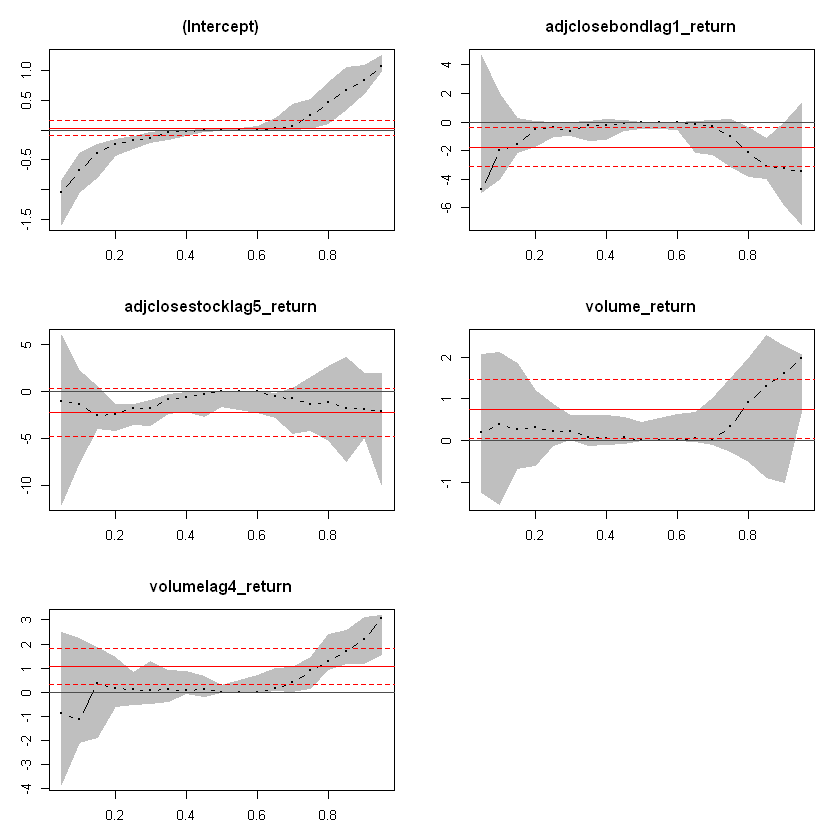

In [12]:

plot(summary(quantile_model))
